<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/student/W1D3_Tutorial4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/student/W1D3_Tutorial4.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# (Bonus) Tutorial 4: Representational geometry & noise

**Week 1, Day 3: Comparing Artificial And Biological Networks**

**By Neuromatch Academy**

__Content creators:__ Wenxuan Guo, Heiko Schütt

__Content reviewers:__ Alish Dipani, Samuele Bolotta, Yizhou Chen, RyeongKyung Yoon, Ruiyi Zhang, Lily Chamakura, Hlib Solodzhuk, Alex Murphy

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk, Patrick Mineault, Alex Murphy

Acknowledgments: the tutorial outline was written by Heiko Schütt. The content was greatly improved by discussions with Heiko, Hlib, and Alish, and the insightful illustrations presented in the paper by Walther et al. (2016)


___


# Tutorial Objectives

Estimated timing of tutorial: 45 minutes.

This tutorial is about measuring the distances that define geometries. In many fields, distances must be estimated from limited and possibly noisy samples.
In AI, we may want to compare models on the basis of samples of their units and inputs, and models may be stochastic. In computational neuroscience, we usually have recordings for samples of neurons, and data are affected by noise.

By completing this tutorial, you will gain insights into:

1. Generating simulated neural data with different noise distributions. This section will guide you through the process of creating simulated neural data and introducing variability in noise distributions. This step will illustrate how different noise levels can affect data representation and subsequent analyses.

2. The Euclidean distance and Mahalanobis distance. Each of these metrics offers unique insights into the geometry of the data.

3. The relationship between distance metrics and binary classification performance. This part of the tutorial emphasizes the relationship between distance measurements and the performance of binary classification tasks on a given pair of stimuli. Understanding this relationship will help us develop more accurate and robust classification models.

4. The positive bias that arises when measuring distances from noisy pattern estimates and how cross-validation can correct this bias and give more accurate estimates of the underlying noise-free distance.

5. Using random projections to estimate distances. This section introduces the Johnson–Lindenstrauss Lemma, which states that random projections maintain the integrity of distance estimates in a lower-dimensional space. This concept is crucial for reducing dimensionality while preserving the relational structure of the data.

We will adhere to the notational conventions established by [Walther et al. (2016)](https://pubmed.ncbi.nlm.nih.gov/26707889/) for all discussed distance measures.

In [1]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
from ipywidgets import widgets
out = widgets.Output()

link_id = "uwn2g"

with out:
    print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
    display(IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=730, height=410))
display(out)

Output()

---
# Setup

In [2]:
# @title Install dependencies and import feedback gadget

!pip install numpy xarray scipy scikit-learn matplotlib seaborn tqdm vibecheck datatops --quiet
!pip install rsatoolbox==0.1.5 --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_neuroai",
            "user_key": "wb2cxze8",
        },
    ).render()

feedback_prefix = "W1D3_T4"

In [3]:
# @title Import dependencies

import logging
from tqdm import tqdm
from itertools import combinations
import numpy as np
import xarray as xr
from scipy.stats import multivariate_normal
from sklearn.model_selection import StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import rsatoolbox.data as rsd
import rsatoolbox.rdm as rsr
import scipy
from scipy.spatial.distance import squareform

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

In [4]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [5]:
# @title Helper functions

def compute_classifier_acc(classifier, neural_data, cov):
    """
    Compute the accuracy of a classifier for all combinations of stimulus pairs in the neural data.

    Parameters:
    - neural_data (xarray.DataArray): neural data with dimensions "stim" and "neuron".

    Returns:
    - acc (xarray.DataArray): Accuracy matrix with dimensions "stim1" and "stim2".
    """
    n_stimuli = len(np.unique(neural_data.stim.values))
    coords = {"stim1": np.arange(n_stimuli), "stim2": np.arange(n_stimuli)}
    acc_init = np.zeros([n_stimuli, n_stimuli])
    acc = np2xr(acc_init, coords)
    whitening_matrix = np.linalg.inv(np.linalg.cholesky(cov))
    whitened_data = neural_data.values @ whitening_matrix
    neural_data = xr.DataArray(whitened_data, dims=neural_data.dims, coords=neural_data.coords)

    for i_stim_idx, j_stim_idx in tqdm(combinations(np.arange(n_stimuli),2)):
        i_stim_pattern = neural_data.sel({"stim":i_stim_idx}) # xarray cannot select two non-unique indices at the same time
        j_stim_pattern = neural_data.sel({"stim":j_stim_idx})
        X = xr.concat([i_stim_pattern, j_stim_pattern], dim="stim")
        y = X.stim.values

        cv = StratifiedKFold()
        for i, (train_index, test_index) in enumerate(cv.split(X, y)):
            classifier.fit(X[train_index].values, y[train_index])
            pred = classifier.predict(X[test_index])
            acc.loc[i_stim_idx, j_stim_idx] += np.sum((pred==y[test_index]))
        acc.loc[i_stim_idx, j_stim_idx] = acc.loc[i_stim_idx, j_stim_idx]/len(y)
        acc.loc[j_stim_idx, i_stim_idx] = acc.loc[i_stim_idx, j_stim_idx]

    return acc

def np2xr(data, coords):
    """
    Convert numpy arrays to labelled xarrays.

    Parameters:
    - data (numpy.ndarray): The data array.
    - coords (dict): A dictionary mapping dimension names to coordinate arrays.

    Returns:
    - xarray.DataArray: The labelled xarray.
    """
    dims = list(coords.keys())
    xarray = xr.DataArray(data, dims=dims, coords=coords)
    return xarray

def generate_activity_patterns(n_stimuli, n_neurons):
    """
    Generate a stimulus x neural response matrix with reasonable Euclidean distances between different stimuli.

    Parameters:
    - n_stimuli (int): The number of stimuli.
    - n_neurons (int): The number of neurons.

    Returns:
    - numpy.ndarray: The generated activity patterns of shape (n_stimuli, n_neurons).
    """
    activity_patterns = np.random.default_rng(seed=0).uniform(low=0.0, high=2.0, size=(n_stimuli, n_neurons))
    if n_neurons > 2:
        # scale the neural response for each stimulus to make the stimuli discriminable for the 100-neuron case
        scale = np.arange(1, n_stimuli+1) * 0.5
        np.random.shuffle(scale)
        activity_patterns *= scale.reshape(-1, 1)
    return activity_patterns

def repeat_first_row(arr):
    """repeat the activity patterns for the first stimuli"""
    return np.vstack((arr,arr[0]))

def generate_activity_patterns_wrapper(n_stimuli, n_neurons):
    """a wrapper for generating the activity patterns for a set of stimuli and labeling the data with xarray"""
    activity_patterns = generate_activity_patterns(n_stimuli-1, n_neurons)
    if n_neurons == 2:
        cov = get_correlated_covariance(n_neurons)
        v = find_contour_direction(cov, p=0.06) * 2
        activity_patterns[1] = activity_patterns[0] + v
        l = np.linalg.norm(v)
        activity_patterns[2] = activity_patterns[0] + np.array([0, l])
    activity_patterns = repeat_first_row(activity_patterns)
    # convert to xarray
    coords={"stim": np.arange(n_stimuli), "neuron": np.arange(n_neurons)}
    activity_patterns = np2xr(activity_patterns, coords)
    return activity_patterns

def get_isotropic_covariance(n_neurons):
    """Generate an isotropic covariance matrix.

    Parameters:
    - n_neurons (int): The number of neurons.
    - noise_std (float): The standard deviation of the noise.

    Returns:
    - numpy.ndarray: The isotropic covariance matrix of shape (n_neurons, n_neurons).
    """
    noise_std = 1.0 if n_neurons==2 else 15.0
    return np.identity(n_neurons) * noise_std**2

def get_correlated_covariance(n_neurons):
    """
    Generate a correlated covariance matrix using a Radial Basis Function (RBF) kernel.

    Parameters:
    - n_neurons (int): The number of neurons.
    - length_scale (float): The length scale parameter for the RBF kernel.
    - noise_amplitude (float, optional): The amplitude of the noise. Default is 1.0.

    Returns:
    - numpy.ndarray: The correlated covariance matrix of shape (n_neurons, n_neurons).
    """
    if n_neurons == 2:
        cov = np.array([1, 0.7, 0.7, 1]).reshape(2,2)*1.4 # make the neurons correlated
    elif n_neurons > 2:
        from sklearn.gaussian_process.kernels import RBF
        noise_amplitude = 50.0
        neuron_idx = np.arange(n_neurons).reshape(-1,1)
        kernel = RBF(length_scale=30)
        cov = kernel(neuron_idx)
        cov = cov*noise_amplitude + np.identity(n_neurons) * 60
    return cov

def find_contour_direction(cov, p):
    """find the ellipse direction for a particular covariance matrix."""
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    assert eigenvalues[0]>np.max(eigenvalues[1:])
    v0=eigenvectors[:,0]
    return v0

def add_correlated_noise(activity_patterns, cov, repetitions=50):
    """
    Add correlated noise to the activity patterns.

    Parameters:
    - activity_patterns (numpy.ndarray): The activity patterns of shape (n_stimuli, n_neurons).
    - cov (numpy.ndarray): The covariance matrix of shape (n_neurons, n_neurons).
    - repetitions (int, optional): The number of repetitions. Default is 5.

    Returns:
    - numpy.ndarray: The activity patterns with added correlated noise of shape
      (n_stimuli * repetitions, n_neurons).
    """

    n_stimuli, n_neurons=activity_patterns.shape
    activity_patterns = np.repeat(activity_patterns, repetitions, axis=0)
    noise = np.random.multivariate_normal(mean=np.zeros(n_neurons), cov=cov, size=n_stimuli * repetitions)
    activity_patterns += noise

    return activity_patterns

def generate_noisy_activity_patterns_wrapper(activity_patterns, repetitions):
    """Generate noisy activity patterns by adding isotropic and correlated noise to the given activity patterns.

    Parameters:
    - activity_patterns (numpy.ndarray): The original activity patterns of shape (n_stimuli, n_neurons).
    - repetitions (int): The number of measurement repetitions.

    Returns:
    - isotropic_noised_data (xarray.DataArray): The activity patterns with added isotropic noise.
    - isotropic_cov (numpy.ndarray): The isotropic covariance matrix.
    - corr_noised_data (xarray.DataArray): The activity patterns with added correlated noise.
    - correlated_cov (numpy.ndarray): The correlated covariance matrix.
    """
    n_stimuli, n_neurons = activity_patterns.shape
    isotropic_cov = get_isotropic_covariance(n_neurons)
    correlated_cov = get_correlated_covariance(n_neurons, length_scale=n_neurons/20)

    isotropic_noised_data = add_correlated_noise(activity_patterns, cov=isotropic_cov, repetitions = repetitions)
    corr_noised_data = add_correlated_noise(activity_patterns, cov=correlated_cov, repetitions = repetitions)

    coords = {"stim": np.arange(n_stimuli).repeat(repetitions), "neuron": np.arange(n_neurons)}
    isotropic_noised_data = np2xr(isotropic_noised_data, coords)
    corr_noised_data = np2xr(corr_noised_data, coords)

    return isotropic_noised_data, isotropic_cov, corr_noised_data, correlated_cov

def calc_rdm(neural_data, method='euclidean', noise=None, normalize_by_channels=True):
    """
    Calculate the representational dissimilarity matrix (RDM) from neural data.

    Parameters:
    - neural_data (xarray.DataArray): Neural data with dimensions "stim" and "neuron".
    - method (str): Dissimilarity measure to use for calculating the RDM. Default is 'euclidean'.
    - noise (float or None): Noise level to add to the dissimilarities. Default is None.
    - normalize_by_channels (bool): rsatoolbox normalize (divide) the distances by the number of channels.
                                    set to False if raw squared euclidean distance is desired.

    Returns:
    - rdm (pyrsa.rdm.rdms.RDMs): representational dissimilarity matrix.
    """

    dataset = rsd.Dataset(measurements=neural_data.values,
                          obs_descriptors={"stim": neural_data.stim.values},
                          channel_descriptors={"neuron": neural_data.neuron.values})
    rdm = rsr.calc_rdm(dataset, method=method, noise=noise, descriptor='stim')
    if not normalize_by_channels:
        n_neurons=len(neural_data.neuron.values)
        rdm.dissimilarities *= n_neurons
    return rdm

def vectorize_matrix(matrix):
    """
    Extract the upper triangular part of a symmetric matrix.

    Parameters:
    - matrix (xarray.DataArray): a symmetric matrix.

    Returns:
    - numpy.ndarray: Vectorized values.
    """
    n=matrix.shape[0]
    return matrix.values[np.triu_indices(n, k = 1)]

In [6]:
# @title Plotting functions

# visualize noise distributions
def visualize_2d_noise(clean_dataset, isotropic_cov, correlated_cov, isotropic_noised_data, correlated_noised_data):
    noise_dists = ["isotropic", "correlated"]
    n_rows, n_cols = len(noise_dists), 2
    fig, ax=plt.subplots(n_rows, n_cols, figsize=(10,8), sharex=True, sharey=True, dpi=135, layout='constrained')
    n_neurons = 2
    stim_idx = [0,1,2]
    marker_types = ["o", "X", "d"]

    alpha = 1
    cmap = pl.cm.Blues
    my_cmap = cmap(np.arange(cmap.N))
    my_cmap[:,-1] = np.linspace(0, alpha, cmap.N)
    my_cmap = ListedColormap(my_cmap)

    for i_noise, noise_dist in enumerate(noise_dists):
        cov = isotropic_cov if noise_dist=='isotropic' else correlated_cov
        r = 3
        x = np.arange(-r, r, 0.025)
        y = np.arange(-r, r, 0.025)
        X, Y = np.meshgrid(x, y)
        pos = np.dstack((X, Y))
        Z = multivariate_normal(mean=[0,0], cov=cov).pdf(pos)

        for i_stim,stim in enumerate(clean_dataset.loc[dict(stim=stim_idx)]):
            zorder=2 if i_stim==0 else 1
            ax[i_noise,0].contourf(stim[0].values+X, stim[1].values+Y, Z, cmap=my_cmap,zorder=zorder)
            ax[i_noise,0].scatter(stim[0], stim[1], color="darkorange", marker=marker_types[i_stim],s=50,zorder=2)
            x, y = clean_dataset.loc[i_stim].values
            ax[i_noise,0].annotate(rf"$s_{i_stim}$", xy=(x-0.4,y+0.2), color="darkorange", fontsize=10, zorder=2)
            if i_stim==0:
                cs=ax[i_noise,1].contourf(stim[0].values+X, stim[1].values+Y, Z, cmap=my_cmap, zorder=1)
                ax[i_noise,1].scatter(stim[0], stim[1], color="darkorange", marker=marker_types[i_stim],s=50,zorder=1)

        x, y = clean_dataset.loc[0].values
        dx1, dy1 = clean_dataset.loc[1].values - clean_dataset.loc[0].values
        dx2, dy2 = clean_dataset.loc[2].values - clean_dataset.loc[0].values
        ax[i_noise,0].arrow(x=x, y=y, dx=dx1*0.9, dy=dy1*0.9, linewidth=2, color="dimgray", head_width=0.1, zorder=2)
        ax[i_noise,0].arrow(x=x, y=y, dx=dx2*0.9, dy=dy2*0.9, linewidth=2, color="dimgray", head_width=0.1, zorder=2)
        ax[i_noise,0].set_xlim(-2,6)
        ax[i_noise,0].set_ylim(-2,6)


        ax[i_noise,0].annotate(f"{noise_dist}\nnoise", xy=(-0.3, 0.5),
                xycoords='axes fraction', ha='center', va='baseline',fontsize=10)

        # noised_data
        data = isotropic_noised_data if noise_dist=='isotropic' else correlated_noised_data
        stim_data = data.loc[dict(stim=0)]
        ax[i_noise,1].scatter(stim_data[:,0], stim_data[:,1], color="darkblue", marker=marker_types[0], alpha=0.3, edgecolor='none')

        for i_col in range(n_cols):
            ax[i_noise, i_col].set_xlabel("neuron 1", fontsize=9)
            ax[i_noise, i_col].set_ylabel("neuron 2", fontsize=9)

    ax[0, 0].annotate("distance between two stimulus pairs", xy=(0.5, 1.05),
                    xycoords='axes fraction', ha='center', va='baseline',fontsize=10)
    ax[0, 1].annotate(r"noisy samples of neural response to $s_0$", xy=(0.5, 1.05),
                    xycoords='axes fraction', ha='center', va='baseline',fontsize=10)


    # we only plot the colorbar for the whole plot
    # because we set the covariance matrices for both isotropic and correlated noise such that their maximum probability density is around 0.16
    cbar=fig.colorbar(cs, ax=ax.ravel().tolist(),fraction=0.02, pad=0.04)
    cbar.set_label('probability density', rotation=270, labelpad=13)

def visualize_100d_noise(isotropic_cov, correlated_cov):

    with plt.xkcd():
        fig,ax=plt.subplots(2, 2, sharey='row', figsize=(12,8), dpi=120)
        noise_dists = ["isotropic", "correlated"]
        n_samples=5

        for i_noise, noise_dist in enumerate(noise_dists):
            cov = isotropic_cov if noise_dist=='isotropic' else correlated_cov
            noise = np.random.multivariate_normal(mean=np.zeros(100), cov=cov, size=n_samples)

            # plot the covariance matrix
            divider = make_axes_locatable(ax[0, i_noise])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            cov = ax[0, i_noise].matshow(cov, cmap='bone')
            fig.colorbar(cov, cax=cax, orientation='vertical')
            ax[0,i_noise].set_title(noise_dist+" noise")

            # plot the noise samples
            for n in noise:
                ax[1, i_noise].plot(n, color=sns.color_palette()[0], linewidth=1)
            ax[1, i_noise].set_box_aspect(0.8)

            ax[0, i_noise].set_xlabel("neuron index")
            ax[0, i_noise].set_ylabel("neuron index")
            ax[1, i_noise].set_xlabel("neuron index")
            ax[1, i_noise].set_ylabel("noise amplitude")
        ax[0,0].annotate("covariance\nmatrix", xy=(-0.4, 0.5), xycoords='axes fraction', ha='center', va='baseline',fontsize=10)
        ax[1,0].annotate(f"{n_samples} samples\nof noise", xy=(-0.35, 0.5), xycoords='axes fraction', ha='center', va='baseline',fontsize=10)

def plot_accuracy_against_distance(acc, rdm_euclidean, rdm_mahalanobis):
    with plt.xkcd():
        fig,ax=plt.subplots(2, 2, figsize=(12,8), sharex='col', sharey=True, dpi=120)
        for i_noise, (noise_type, acc_val) in enumerate(acc.items()):
            for i_dist, distance in enumerate(["Euclidean", "Mahalanobis"]):
                rdm = rdm_euclidean if distance == 'Euclidean' else rdm_mahalanobis
                # make sure the rdm matrix and accuracy matrix organize the stimuli in the same order
                assert rdm.pattern_descriptors['stim'] == acc_val.stim1.values.tolist()
                x = rdm.dissimilarities.squeeze()
                y = vectorize_matrix(acc_val)
                sns.regplot(x=x, y=y, ax=ax[i_noise, i_dist], ci=None, scatter_kws={'alpha':0.7}, color=f"C{i_dist}")
                r, p = scipy.stats.pearsonr(x, y)
                ax[i_noise, i_dist].annotate('r={:.2f}, p={:.2g}'.format(r, p), xy=(0.2,0.9), xycoords='axes fraction', ha='center', va='baseline',fontsize=12)
                ax[1, i_dist].set_xlabel(f"squared {distance} distance")
                if i_dist == 0:
                    ax[i_noise,0].annotate(noise_type + "\nnoise", xy=(-0.25, 0.5), xycoords='axes fraction', ha='center', va='baseline',fontsize=12)

            ax[i_noise,0].set_ylabel("decoding accuracy")
        plt.tight_layout()
        return fig

def plot_estimated_distance(ground_truth_rdm, noisy_rdm_euclidean, noisy_rdm_crossclidean, n_neurons=100):
    with plt.xkcd():
        fig, ax=plt.subplots(2, 2, figsize=(6.5,6), sharey='row', sharex='row',dpi=150)

        for i, noise_dist in enumerate(['isotropic', 'correlated']):
            for j, rdm in enumerate([noisy_rdm_euclidean, noisy_rdm_crossclidean]):
                ylabel="squared Euclidean" if j==0 else "cross-validated squared Euclidean distance"
                # check the order of the stimuli in both RDMs is matched (note: rsatoolbox automatically sort stimuli based on values)
                assert rdm[n_neurons][noise_dist].pattern_descriptors['stim'] == ground_truth_rdm[n_neurons].pattern_descriptors['stim']
                ax[i,j].scatter(ground_truth_rdm[n_neurons].dissimilarities.squeeze(),
                                rdm[n_neurons][noise_dist].dissimilarities.squeeze(),
                                color=f"C{i}",s=20
                            )
                max_dist=np.ceil(rdm[n_neurons][noise_dist].dissimilarities.max())
                ax[i,j].plot(np.arange(-1,100), np.arange(-1,100), linestyle='dashed', color='gray')
                ax[i,j].set_ylabel("estimated squared Euclidean distance\n(from noisy patterns)", fontsize=7)
                ax[i,j].set_xlabel("ground truth euclidean distance\n(no noise)", fontsize=7)
                ax[i,j].set_xlim(0, max_dist+3)
                ax[i,j].set_ylim(0, max_dist+3)
                ax[i,j].tick_params(axis='both', which='major', labelsize=6)

                title="squared Euclidean" if j==0 else "cross-validated squared Euclidean"

                if i==0:
                    # ax[i,j].annotate(noise_dist, xy=(0.5, 1.05),
                    #             xycoords='axes fraction', ha='center', va='baseline',fontsize=9)
                    ax[i,j].set_title(title, fontsize=12)

            ax[i,0].annotate(f"{noise_dist}\nnoise", xy=(-0.4, 0.5),
                        xycoords='axes fraction', ha='center', va='baseline',fontsize=9)
        plt.tight_layout()

def plot_distance_after_projection(true_dist, projected_dist, n_neurons_list, n_dims_list):
    with plt.xkcd():
        fig, ax=plt.subplots(1, 2, figsize=(6,2.5), dpi=200)
        for i, n_neurons in enumerate(n_neurons_list):
            if n_neurons == 100:
                projected_dist[n_neurons] = projected_dist[n_neurons]/100
                true_dist[n_neurons] = true_dist[n_neurons]/100
            ax[i].scatter(x = n_dims_list, y=projected_dist[n_neurons],s=15)
            ax[i].set_ylabel("squared euclidean distance\nafter random projection", fontsize=6)
            ax[i].set_xlabel("dimensionality", fontsize=7)
            ax[i].tick_params(axis='both', which='major', labelsize=5)
            ax[i].axhline(y=true_dist[n_neurons], linestyle="dashed", color="gray")
            ax[i].text(n_dims_list[-1], true_dist[n_neurons], 'true euclidean distance', color='gray', ha='right', va='top', fontsize=4)
            title = "two neurons" if n_neurons == 2 else "100 neurons"
            ax[i].set_title(title, fontsize=7)
        plt.tight_layout()

In [ ]:
# @title Video 1: Tutorial Introduction

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', '2cMfsTw7YsI'), ('Bilibili', 'BV1Tx4y1t7nL')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

The video below is additional information in more detail which was previously part of the introductory video for this course day. It provides some useful further information on the technical details mentioned during these tutorials. Please feel free to check it out and use it as a resource if you want to learn more or if you want to get a deeper understanding on some of the important details.

In [ ]:
# @title Video 2 (BONUS): Extended Intro Video

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

#assert 1 == 0, "Upload this video"
video_ids = [('Youtube', 'm9srqTx5ci0'), ('Bilibili', 'BV1meVjz3Eeh')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [7]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_tutorial_introduction")

---
# Section 1: Simulate neural data and visualize noise distributions

Estimated timing to here from start of tutorial: 15 minutes

<img src="https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/static/response_matrix.png?raw=true" width=600 />

We will start by generating two neural datasets in response to a set of stimuli, represented as a stimulus-response matrix (stimuli x neurons). The first dataset will be low-dimensional, containing only two neurons, to help with illustration and visualization. The second dataset will be high-dimensional, containing 100 neurons. Each will have 10 stimuli.

The mean activity pattern of each stimulus (each row of the matrix) is generated by randomly sampling from a uniform distribution. To ensure that the differences between the mean activity of different stimuli are distinct for later illustration, we scale each activity pattern by a constant for the 100-neuron dataset. This adds some structure to the simulated representational geometry as observed in neural data, whereas, for randomly sampled patterns in a high-dimensional space, the patterns of each pair tend to be similarly far apart. The implementations can be found above in the `generate_activity_patterns` function.

Then, we add two types of additive noise to the mean activity patterns. The first type of noise is Gaussian and independent between neurons (**isotropic**) and stimuli (**homoscedastic**). The second type of noise is Gaussian and independent between stimuli (**homoscedastic**) but correlated between neurons (**nonisotropic**). *Note that we are not aiming to simulate biologically plausible neural activity patterns, which would have different noise distributions.* The noise we add may lead to negative response values in the neural data.

We will provide various visualizations of the noise to help build intuitions. If you are curious about the implementations, please refer to the `get_isotropic_covariance` and `get_correlated_covariance` functions.

In [8]:
n_stimuli=10
n_neurons_list=[2, 100]

clean_dataset={}
for n_neurons in n_neurons_list:
    clean_dataset[n_neurons] = generate_activity_patterns_wrapper(n_stimuli=n_stimuli, n_neurons=n_neurons)

To simulate noisy measurements, we introduce isotropic or correlated noise to the clean (true) activity patterns and repeat this process to obtain multiple noisy simulated neural measurements of responses to the same stimulus. This is analogous to a neurophysiological experiment where we repeatedly measure the response pattern to each stimulus: each measurement reflects the same true pattern but is affected by new noise.

## Coding Exercise 1

How would you implement isotropic or correlated Gaussian noise for two neurons? Create a covariance matrix for each type of noise:

* For the isotropic Gaussian, let the variance of each neuron be 1.
* For the correlated Gaussian, let the variance of each neuron be 1 and the covariance be 0.6.

**Hint**: Let our covariance matrix be $\Sigma$. The diagonal entry $\Sigma_{i,i}$ represents the variance of element $i$, and the off-diagonal entry $\Sigma_{i,j}$ (where $i\neq j$) represents the covariance between two elements $i$ and $j$. As a result, isotropic Gaussian noise can be represented by a diagonal matrix (where off-diagonal entries are 0). The correlated covariance matrix can be represented by a symmetric non-diagonal matrix ($\Sigma_{i,j}=\Sigma_{j,i})$.

In [10]:
#################################################
## TODO for students: fill in the missing variables ##
# raise NotImplementedError("Student exercise")
#################################################
n_neurons = 2
isotropic_cov_2d = np.identity(n_neurons)
correlated_cov_2d = np.array([[1.0,0.6],[0.6,1.0]])

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/solutions/W1D3_Tutorial4_Solution_b21e3c22.py)



We have implemented the covariance matrices for you. Run the following code block to generate 100 noisy neural responses to the 10 stimuli for different correlation structures.

In [11]:
# @title Generate data

repetitions=100

isotropic_noised_data = {}
isotropic_cov = {} # covariance matrix for the isotropic noise
correlated_noised_data = {}
correlated_cov = {}
for n_neurons in n_neurons_list:
    coords = {"stim": np.arange(n_stimuli).repeat(repetitions), "neuron": np.arange(n_neurons)}

    # add isotropic noise
    isotropic_cov[n_neurons] = get_isotropic_covariance(n_neurons)
    isotropic_noised_data[n_neurons] = add_correlated_noise(clean_dataset[n_neurons],
                                                            cov=isotropic_cov[n_neurons],
                                                            repetitions = repetitions)
    isotropic_noised_data[n_neurons] = np2xr(isotropic_noised_data[n_neurons], coords)

    # add correlated noise
    correlated_cov[n_neurons] = get_correlated_covariance(n_neurons)
    correlated_noised_data[n_neurons] = add_correlated_noise(clean_dataset[n_neurons],
                                                             cov=correlated_cov[n_neurons],
                                                             repetitions = repetitions)
    correlated_noised_data[n_neurons] = np2xr(correlated_noised_data[n_neurons], coords)

Let's visualize the effect of the noise distribution on the distances between the stimuli using the two-neuron dataset.

We can represent the noise distribution using a contour plot centered around the mean stimulus response. The contour plot represents a three-dimensional surface on a two-dimensional plane. In this case, the two dimensions represent the responses of the two neurons, and the contours indicate the probability density of the noise distribution. Darker colors indicate higher probability density. As we move further away from the mean response for a particular stimulus, the probability density decreases, meaning that the likelihood of observing a neural response at that point is lower.

We have generated the clean activity patterns such that the Euclidean distances between stimulus pairs [$s_0$, $s_1$] and [$s_0$, $s_2$] are the same (see the arrows in the left panels). However, depending on the noise distribution, the discriminability of the stimulus pairs is different:

- **Isotropic noise** (first row): the likelihood of observing the mean neural response of $s_1$ and $s_2$, given that the stimulus shown is $s_0$, is the same. The discriminability between a pair of stimuli is precisely defined by the Euclidean distance (Kriegeskorte & Diedrichsen, 2019).
- **Correlated noise** (second row): even though the Euclidean distance between the two stimulus pairs is the same, the discriminability between $s_0$ and $s_1$ is lower than between $s_0$ and $s_2$. This is because the direction of the noise aligns with the signal direction for $s_0$ and $s_1$ (the line connecting their mean responses). As a result, the mean stimulus response of $s_1$ lies within the colored contours of stimulus $s_0$ (the probability density lies roughly between 0.06 and 0.08), while the mean stimulus response of $s_2$ lies outside the contours (which represent the regions where the probability density is close to 0). Namely, when the stimulus shown is $s_0$, the likelihood of observing a neural response that coincides with the mean response of $s_1$ is much higher than the likelihood of observing a neural response that coincides with the mean response of $s_2$. As we will see later, the discriminability depends on the Mahalanobis distance that takes into account the noise covariances between the neurons.

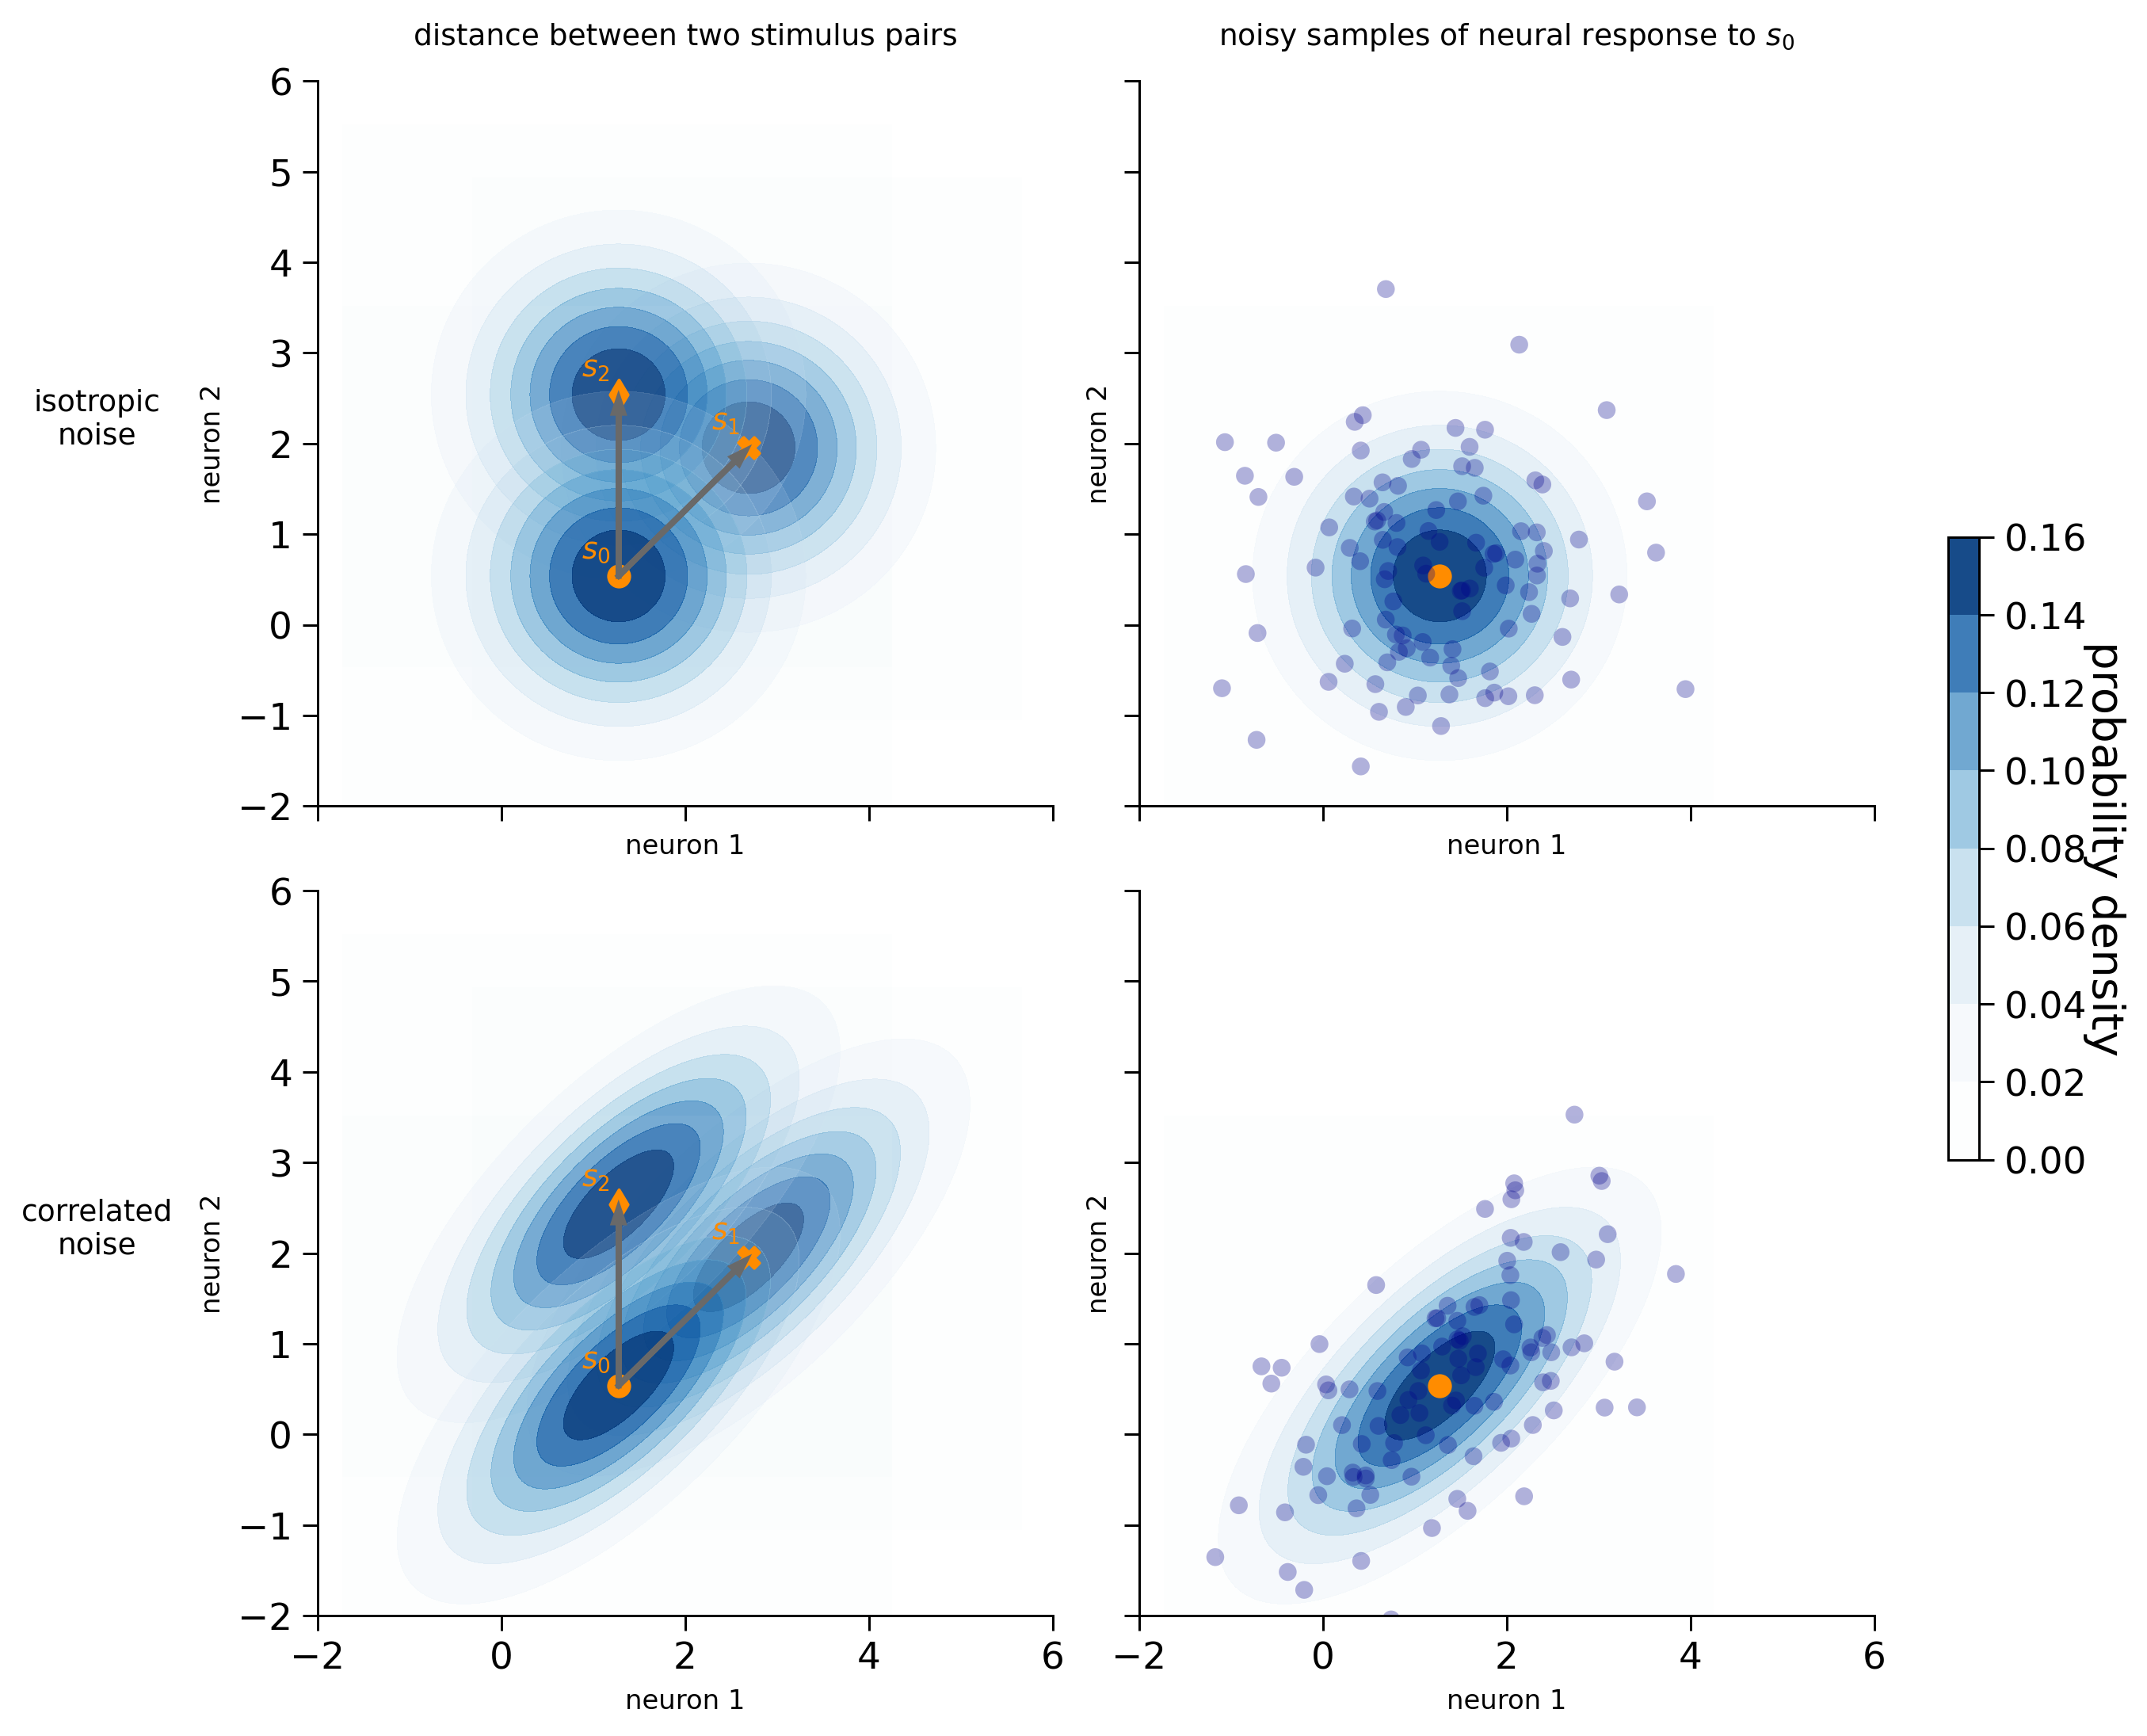

In [12]:
n_neurons = 2
visualize_2d_noise(clean_dataset[n_neurons], isotropic_cov[n_neurons], correlated_cov[n_neurons], isotropic_noised_data[n_neurons], correlated_noised_data[n_neurons])

Let's create covariance matrices for the 100 neuron dataset. For isotropic noise, the covariance between different neurons remains 0, resulting in a diagonal covariance matrix. To create a correlated covariance matrix, we imagine that the neurons are spatially arranged in a line, and their correlation decays with distance:

$$\Sigma_{i,j}=\exp\Big(-\dfrac{||i-j||^2_2}{2l^2}\Big)$$

Here $||i-j||_2$ represents the Euclidean distance between indices $i$ and $j$, and $l$ is a length scale parameter. Assuming that the matrix indices indicate the neurons' positions in the brain, neighboring neurons tend to be correlated. To ensure that the correlated covariance matrix is well-conditioned and not singular, we added a small constant value to its diagonal entries.

Note: we intentionally set the noise magnitude to be large so that decoding the neural responses would not be perfect. This allows us to better illustrate the relationship between decoding accuracy and the distances between stimuli in Section 2.

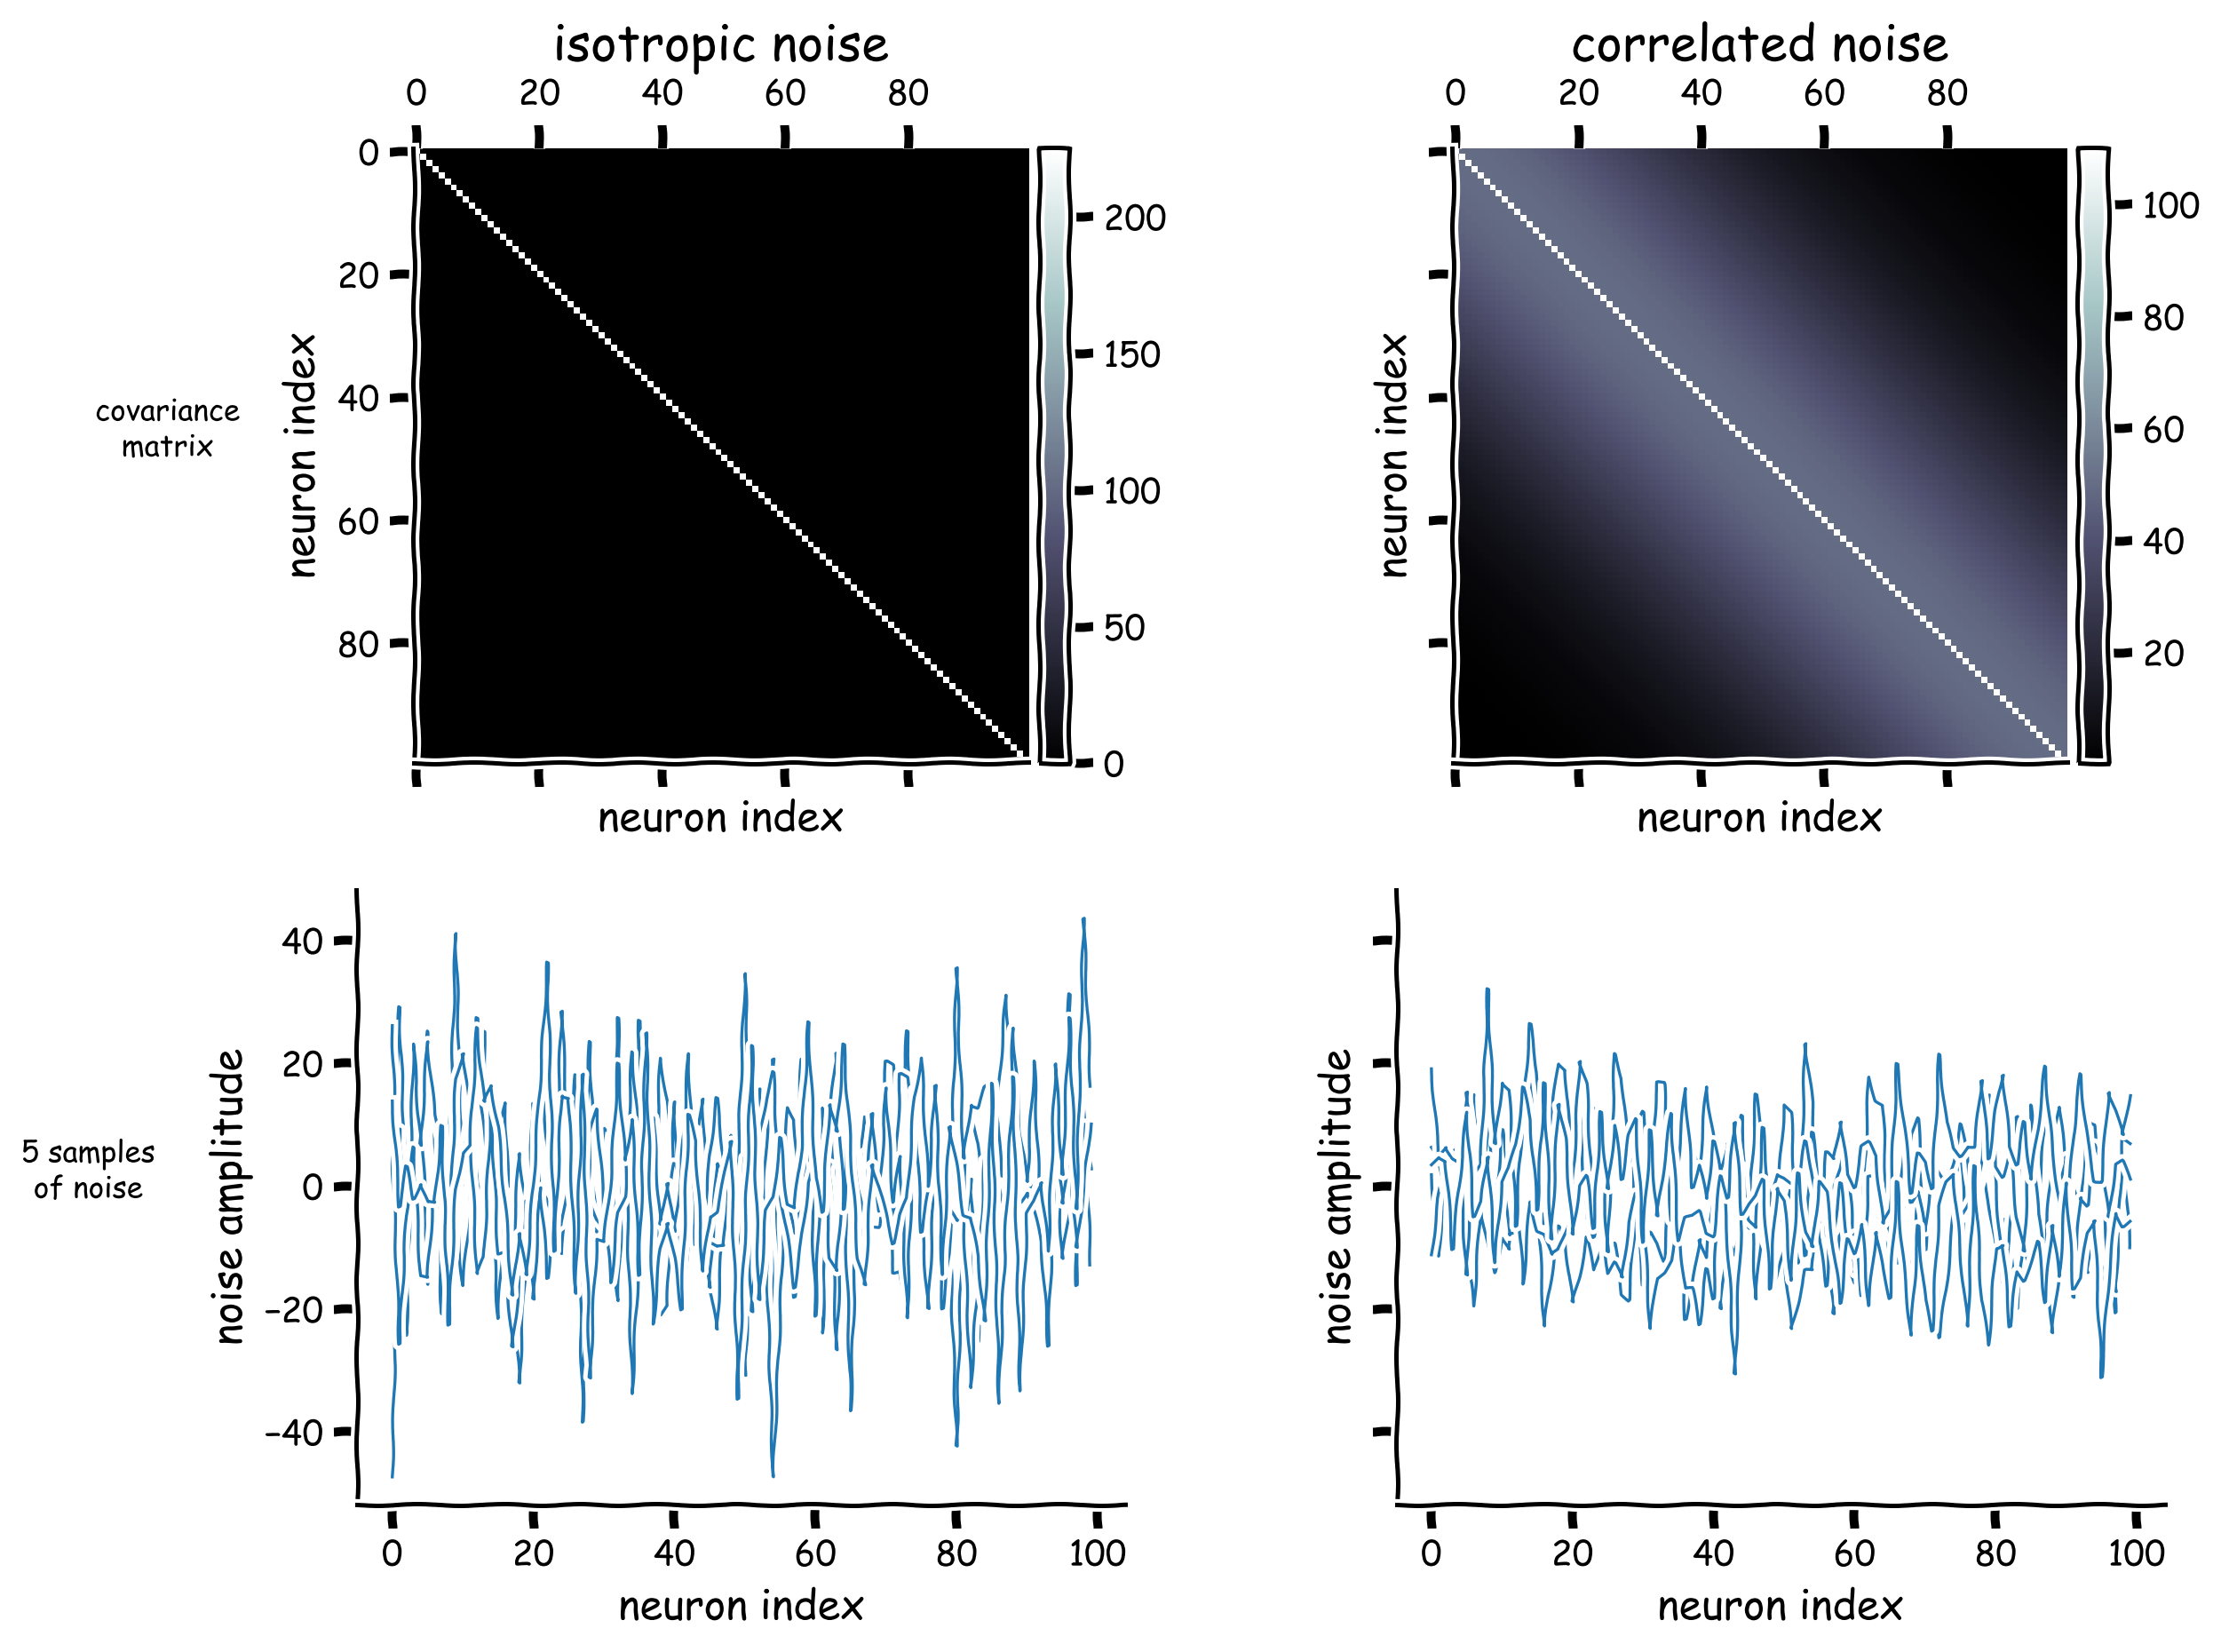

In [13]:
n_neurons = 100
visualize_100d_noise(isotropic_cov[n_neurons], correlated_cov[n_neurons])

In [14]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_noise_representation")

---
# Section 2: Distances and discriminability between a pair of stimuli

Estimated timing to here from start of tutorial: 30 minutes

As we alluded to earlier, for a pair of stimuli, there is a strong dependence between their distance and their discriminability (defined by the performance of a binary classifier for the stimulus pair). Moreover, matching the type of distance computed (Euclidean vs. Mahalanobis) and the noise distribution (isotropic vs. correlated) is important. <be>

Let's briefly review how to compute the Euclidean and Mahalanobis distance. Let the activity patterns of stimuli $j$ and $k$ be $\mathbf{b_j}$ and $\mathbf{b_k}$ respectively.
- The *squared* Euclidean distance is:
  
$$d^2_{\text{Euclidean}}=||\mathbf{b_i}-\mathbf{b_j}||^2=(\mathbf{b_i} - \mathbf{b_j})(\mathbf{b_i} - \mathbf{b_j})^T$$

- The *squared* mahalanobis distance is:

$$d^2_{\text{Mahalanobis}}=(\mathbf{b_i} - \mathbf{b_j})\Sigma^{-1}(\mathbf{b_i} - \mathbf{b_j})^T$$

where $\Sigma$ is the covariance matrix across the neurons. Taking the inverse of the covariance matrix makes the noise approximately independent and identically distributed. Intuitively, the noisier a neuron is, the more we down-weight its response.
Note: If we have repeated measurements for some stimulus $j$ ($\mathbf{b_j^1}, \mathbf{b_j^2}, ..., \mathbf{b_j^n}$), we take the average and compute $\mathbf{b_j}=\dfrac{1}{n}\sum_{i=1}^n \mathbf{b_j^i}$

Let's first train a binary classifier for each pair of stimuli and calculate the decoding accuracy. We will use the **Fisher Linear Discriminant Analysis**.

To classify two stimuli $i$ and $j$, the Fisher discriminant decision criterion is a threshold on the dot product $\mathbf{wb}^T > c$, where $\mathbf{w}=(\mathbf{b_i}-\mathbf{b_j})_{\text{train}}\Sigma_{\text{train}}^{-1}$ is the weight vector and $\mathbf{b}$ is the stimulus pattern we want to classify.

Execute this cell below to calculate the classifier performance on the noisy data (generated by adding either isotropic or correlated noise).

In [15]:
classifier = LinearDiscriminantAnalysis()
acc = {}
for n_neurons in n_neurons_list:
    print(f"Fitting for {n_neurons} neurons")
    acc[n_neurons]={}
    acc[n_neurons]['isotropic'] = compute_classifier_acc(classifier, isotropic_noised_data[n_neurons], cov=isotropic_cov[n_neurons])
    acc[n_neurons]['correlated'] = compute_classifier_acc(classifier, correlated_noised_data[n_neurons], cov=correlated_cov[n_neurons])

Fitting for 2 neurons


45it [00:00, 106.92it/s]
45it [00:00, 110.91it/s]


Fitting for 100 neurons


45it [00:02, 22.39it/s]
45it [00:01, 22.60it/s]


Let's calculate the *squared* Euclidean and Mahalanobis distances between the **clean neural activity** patterns to study the relationship between these distances and classification accuracy.

## Coding exercise 2: Distance-metrics comparison

In this coding exercise, you'll compute the *squared* Euclidean and Mahalanobis distance for *one pair* of stimuli in the 2-neuron dataset.

You might be wondering why we are calculating the Mahalanobis distance for clean neural patterns, given that they are inherently noiseless. The reason is that our binary decoders are trained to classify noisy data. By computing the Mahalanobis distance between the clean neural activity patterns, we take the covariances into account, which allows us to better predict decoding accuracy (as you will see below). Consider the clean neural activity patterns as the mean neural response obtained from repeated measurements. If we collect many noisy measurements, our mean neural response will converge to the clean neural pattern.

 The equations are provided again below:

$$d^2_{\text{Euclidean}}=||\mathbf{b_j}-\mathbf{b_k}||^2=(\mathbf{b_i} - \mathbf{b_j})(\mathbf{b_i} - \mathbf{b_j})^T$$

$$d^2_{\text{Mahalanobis}}=(\mathbf{b_i} - \mathbf{b_j})\Sigma^{-1}(\mathbf{b_i} - \mathbf{b_j})^T$$

where $\Sigma$ is the covariance matrix across the neurons.

In [18]:
n_neurons = 2
stimulus_idx = 0,1 # choose two stimuli
#################################################
# raise NotImplementedError("Student exercise: complete Euclidean distance calculation by the formula provided above")
#################################################
b_j = clean_dataset[n_neurons].loc[stimulus_idx[0]].values # select the stimulus response
b_k = clean_dataset[n_neurons].loc[stimulus_idx[1]].values
# compute the squared euclidean and mahalanobis distance, and then divide the distance by the number of neurons (2)
euclidean_dist = ((b_j-b_k) @ (b_j-b_k).T) / n_neurons
mahalanobis_dist = ((b_j-b_k) @ np.linalg.inv(correlated_cov[n_neurons]) @ (b_j-b_k).T) / n_neurons

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/solutions/W1D3_Tutorial4_Solution_3c63934e.py)



### Coding Exercise 2 Discussion

1. For isotropic Gaussian noise, what is the relationship between Euclidean and Mahalanobis distance?
**Hint**: Check the equations above. In the special case of an identity covariance matrix, i.e., $\Sigma=I$, what is the inverse of $\Sigma$?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/solutions/W1D3_Tutorial4_Solution_6c059522.py)

For isotropic Gaussian noise, the Euclidean distance and Mahalanobis distance are equivalent up to a constant factor. When the covariance matrix is an identity matrix, the Euclidean and Mahalanobis distances are exactly equal.

The distances for all stimulus pairs in the 2-neuron and 100-neuron datasets are computed below. The`calc_rdm` function is a wrapper around the `rsatoolbox.data.Dataset` and `rsatoolbox.rdm.calc_rdm` modules in the [rsatoolbox](https://github.com/rsagroup/rsatoolbox) package. The rsatoolbox automatically computes distances for all possible pairs of stimuli. Namely, if our `clean_dataset` is an array of $k$ stimuli by $n$ neurons, then `rsatoolbox.rdm.calc_rdm` computes $k(k-1)/2$ distances.

In [19]:
rdm_euclidean, rdm_mahalanobis = {}, {}
for n_neurons in n_neurons_list:
    rdm_euclidean[n_neurons] = calc_rdm(clean_dataset[n_neurons], method='euclidean')
    rdm_mahalanobis[n_neurons] = calc_rdm(clean_dataset[n_neurons], method='mahalanobis', noise=np.linalg.inv(correlated_cov[n_neurons])) # plotting decoding accuracy from isotropic noise data

Verify that the distances you just computed correspond to the ones calculated by rsatoolbox. Note that the `calc_rdm` function normalizes the distance by the number of channels (e.g., divides the distance by 2 for the 2-neuron dataset), so please divide your distance by the number of neurons (2) as well.

You can obtain the distances by accessing the `dissimilarities` property in the namespace (`rdm_euclidean[n_neurons].dissimilarities`). The `dissimilarities` are ordered by the `pattern_descriptors`. If the pattern descriptor shows [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], then the $9(9-1)/2=45$ distances are ordered as $d_{0,1}$, $d_{0,2}$, $d_{0,3}$,..., $d_{i,i+1}$, $d_{i,i+2}$, ..., $d_{8,9}$.

In [20]:
rdm_euclidean[2] # access dissimilarities by rdm_euclidean[2].dissimilarities
rdm_euclidean[2].dissimilarities

array([[2.        , 2.        , 0.42450561, 0.90263363, 0.2066341 ,
        0.20877183, 0.03490559, 0.24996255, 0.        , 1.17157288,
        1.21002444, 1.28491752, 2.4559779 , 2.25334373, 2.03897099,
        0.84171204, 2.        , 0.58566622, 0.24149079, 3.27482695,
        3.15357638, 2.41142996, 1.16326452, 2.        , 0.09246359,
        1.14389872, 1.09435388, 0.64374725, 0.20234335, 0.42450561,
        1.88670987, 1.82227196, 1.22264242, 0.51408899, 0.90263363,
        0.00535601, 0.07466089, 0.58492372, 0.2066341 , 0.07300732,
        0.51594203, 0.20877183, 0.30328451, 0.03490559, 0.24996255]])

For each pair of stimuli, we can plot the decoding accuracy and the distance between them. We will generate four plots for each dataset, two noise distributions (isotropic or correlated) $\times$ two distance measures (Euclidean or mahalanobis).

Text(0.5, 0.98, '100 neurons')

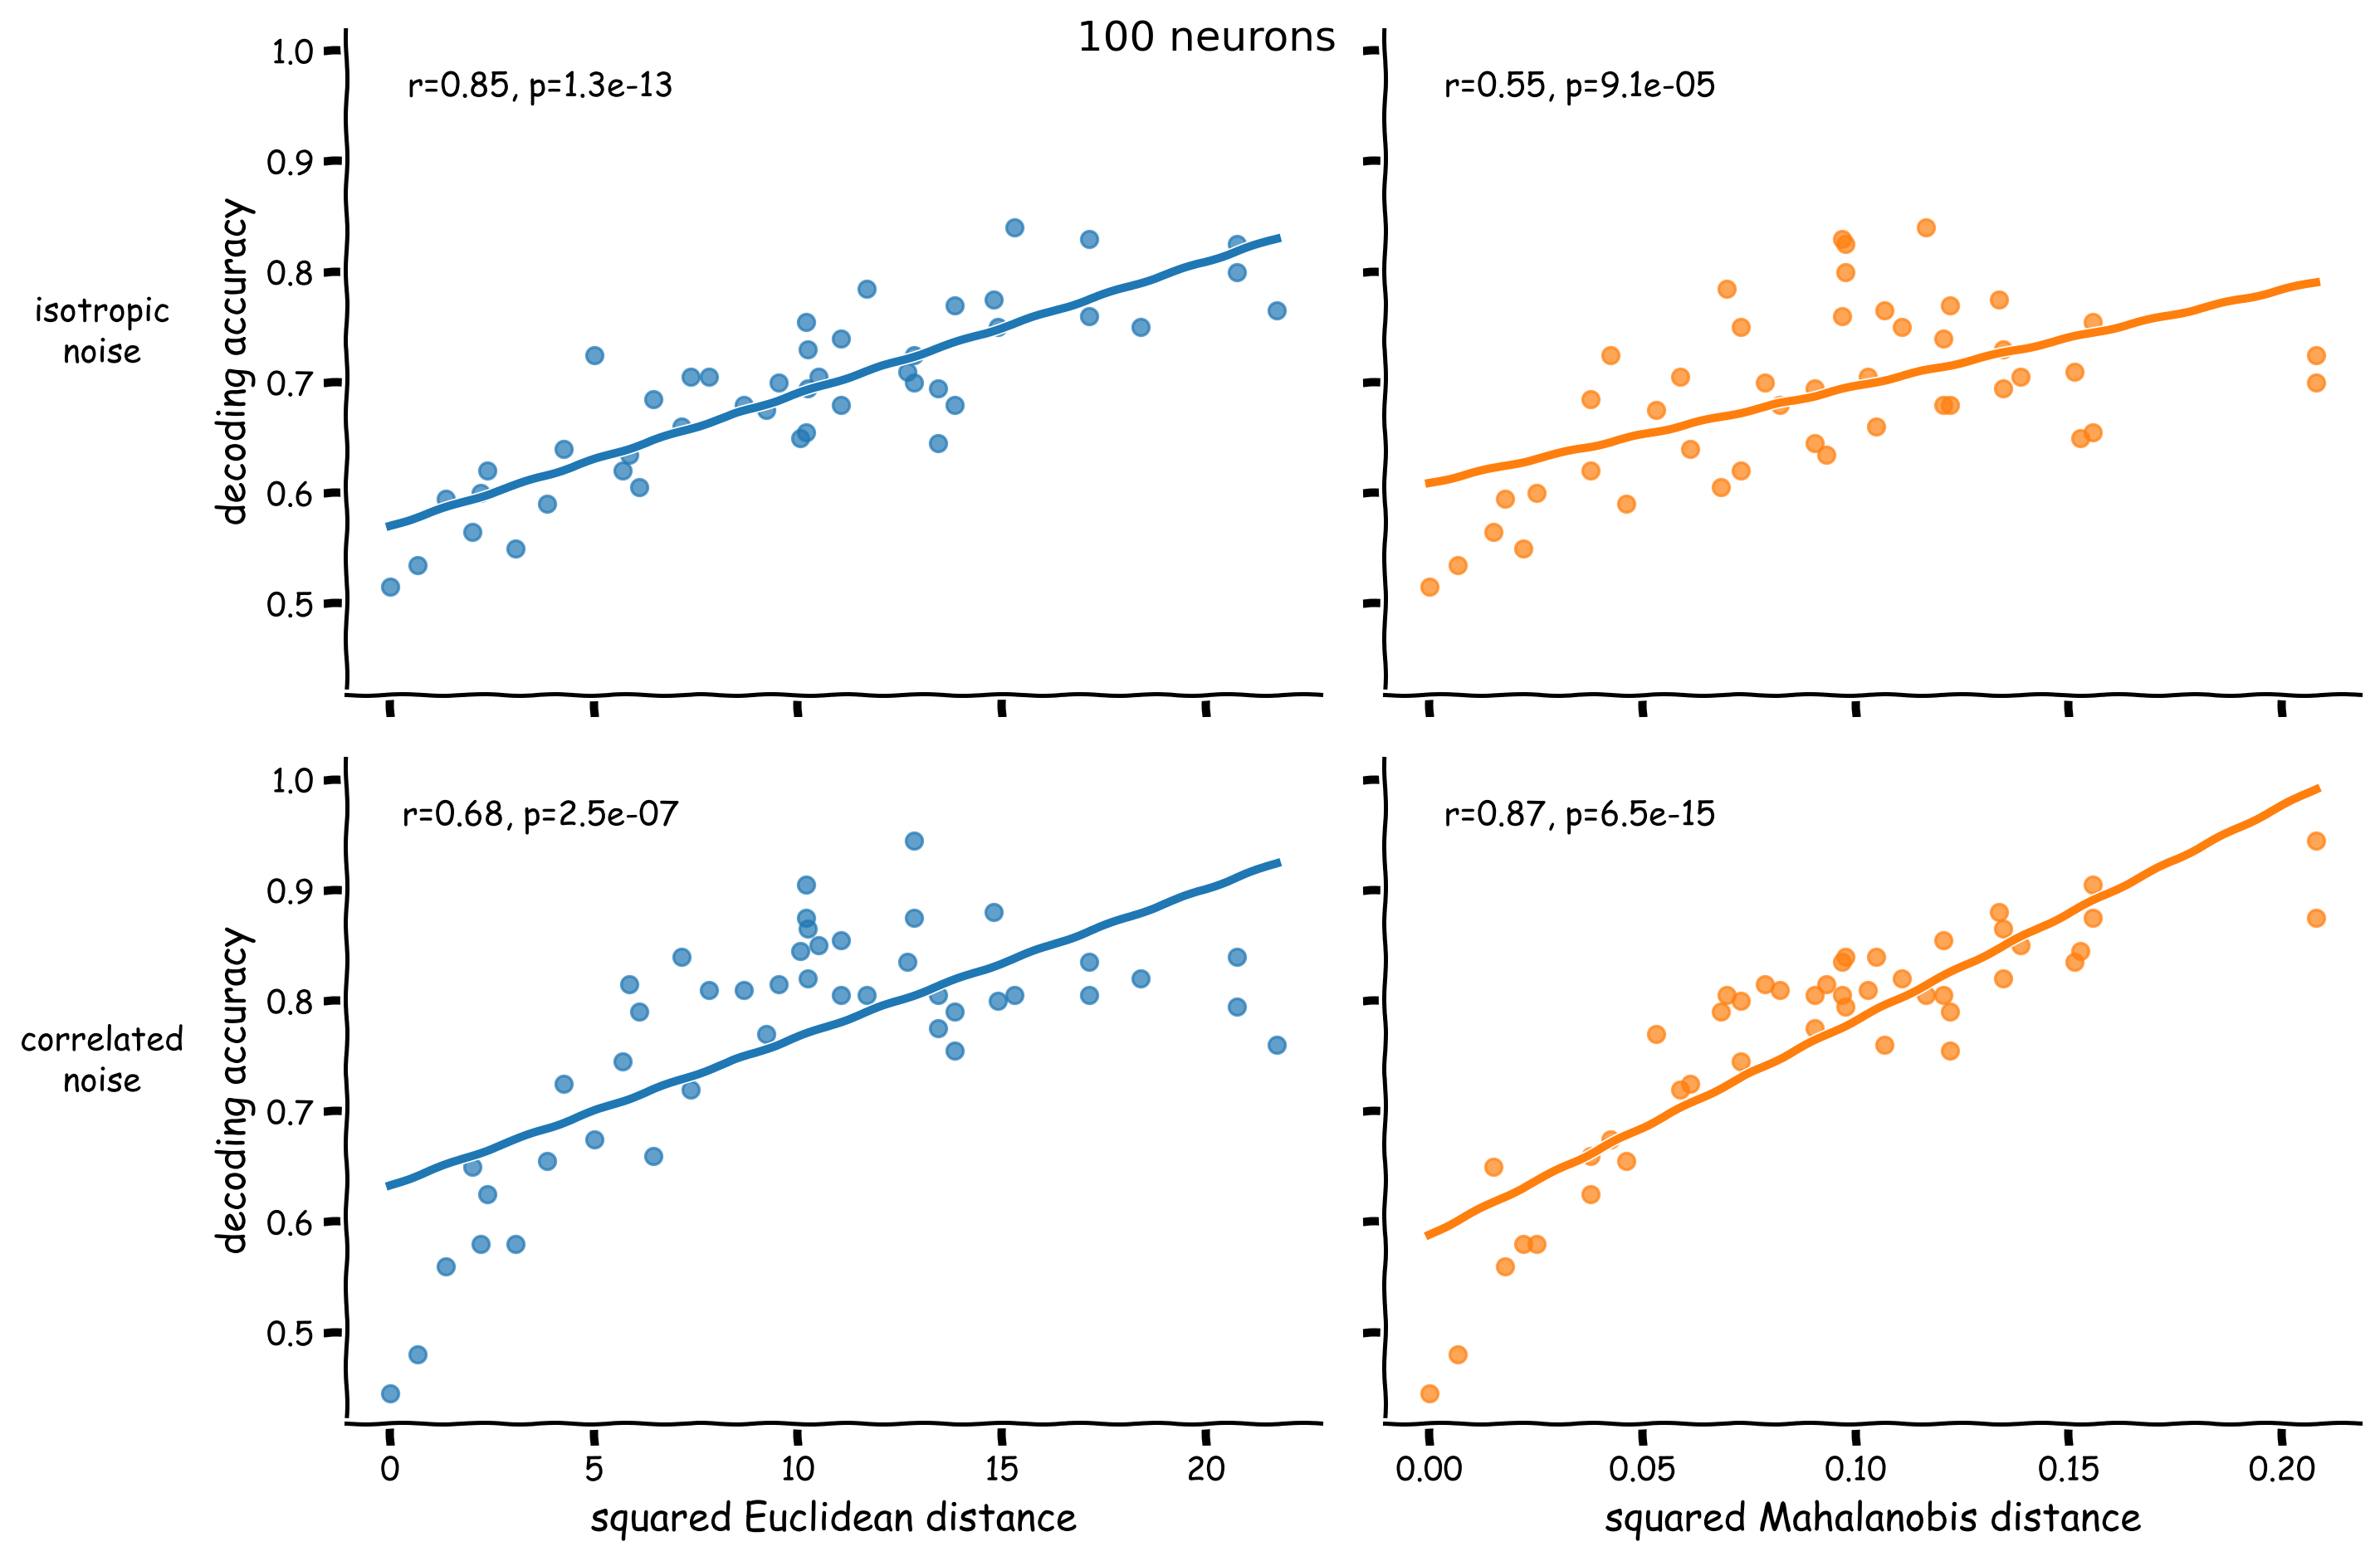

In [22]:
n_neurons = 100 # change to 100 to visualize the relationship between distance and decoding accuracy for the 100-neuron dataset
fig = plot_accuracy_against_distance(acc[n_neurons], rdm_euclidean[n_neurons], rdm_mahalanobis[n_neurons])
fig.suptitle(f"{n_neurons} neurons", fontsize=15)

Notice that:
- For a decoder trained to classify data with isotropic noise, the Euclidean distance predicts decoding accuracy better (higher correlation). The Mahalanobis distance predictions are less accurate because this distance uses the correlated covariance, which doesn't reflect the isotropic noise.
- For a decoder trained to classify data with correlated noise, the Mahalanobis distance that takes into account the correct noise covariance predicts decoding accuracy better.

In [23]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_distance_metrics_comparison")

---
# Section 3: Cross-validated distances prevent the inflation of distance estimates by noise

Estimated timing to here from start of tutorial: 40 minutes


If we calculate the Euclidean distance between the **noisy** activity patterns of each pair of stimuli, we will observe that it's higher than in the no-noise condition. This is especially visible in the 100-neuron dataset.

To understand this positive bias of distances, imagine two activity patterns that are, in truth, identical. With the addition of the noise, the estimated distance between the noisy data will always be larger than 0. The noise makes the patterns dissimilar and inflates the distance (Walther et al. 2016). This effect is particularly pronounced in high-dimensional data.

Let's first calculate the squared Euclidean distances between the noisy activity patterns of each stimulus pair.

In [24]:
noisy_rdm_euclidean = {}
for n_neurons in n_neurons_list:
    noisy_rdm_euclidean[n_neurons] = {}
    noisy_rdm_euclidean[n_neurons]['isotropic'] = calc_rdm(isotropic_noised_data[n_neurons], method='euclidean')
    noisy_rdm_euclidean[n_neurons]['correlated'] = calc_rdm(correlated_noised_data[n_neurons], method='euclidean')

d:\Anaconda\envs\neuro\lib\site-packages\numpy\_core\numeric.py:442: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


To obtain an unbiased estimate, we can split the data into independent sets and cross-validate the difference between patterns across the two sets (Allefeld and Haynes, 2014; Nili et al. 2014).

The cross-validated squared Euclidean distance–the so-called *crossclidian*–between two activity patterns $\mathbf{b_i}$ and $\mathbf{b_j}$ can be computed as:

$$d^2_{\text{Euclidean, cross-validated}}=(\mathbf{b_i} - \mathbf{b_j})_\text{train}(\mathbf{b_i} - \mathbf{b_j})_\text{test}^T$$


where we partition the repeated measurements of the activity patterns into a training and testing set before computing the difference vectors independently.

`rsatoolbox` has an implementation of the cross-validated distance. The general distance measure is called *crossnobis*, short for *cross-validated mahalanobis distance*.

$$d^2_{\text{Mahalanobis, cross-validated}}=(\mathbf{b_i} - \mathbf{b_j})_\text{train}\Sigma_{\text{train}}^{-1}(\mathbf{b_i} - \mathbf{b_j})_\text{test}^T$$

If we assume the covariance noise structure is an identity matrix, then the crossnobis distance is equivalent to the cross-validated Euclidean distance.

In [25]:
noisy_rdm_crossclidean = {}
for n_neurons in n_neurons_list:
    noisy_rdm_crossclidean[n_neurons] = {}
    noisy_rdm_crossclidean[n_neurons]['isotropic'] = calc_rdm(isotropic_noised_data[n_neurons], method='crossnobis', noise=None)
    noisy_rdm_crossclidean[n_neurons]['correlated'] = calc_rdm(correlated_noised_data[n_neurons], method='crossnobis', noise=None)

Let's now plot the squared Euclidean distance and the cross-validated squared Euclidean distance against the true Euclidean distance for the 100-neuron dataset. Points falling on the diagonal line indicate an unbiased estimate of the distance; points above the diagonal line indicate an overestimation of the distance.

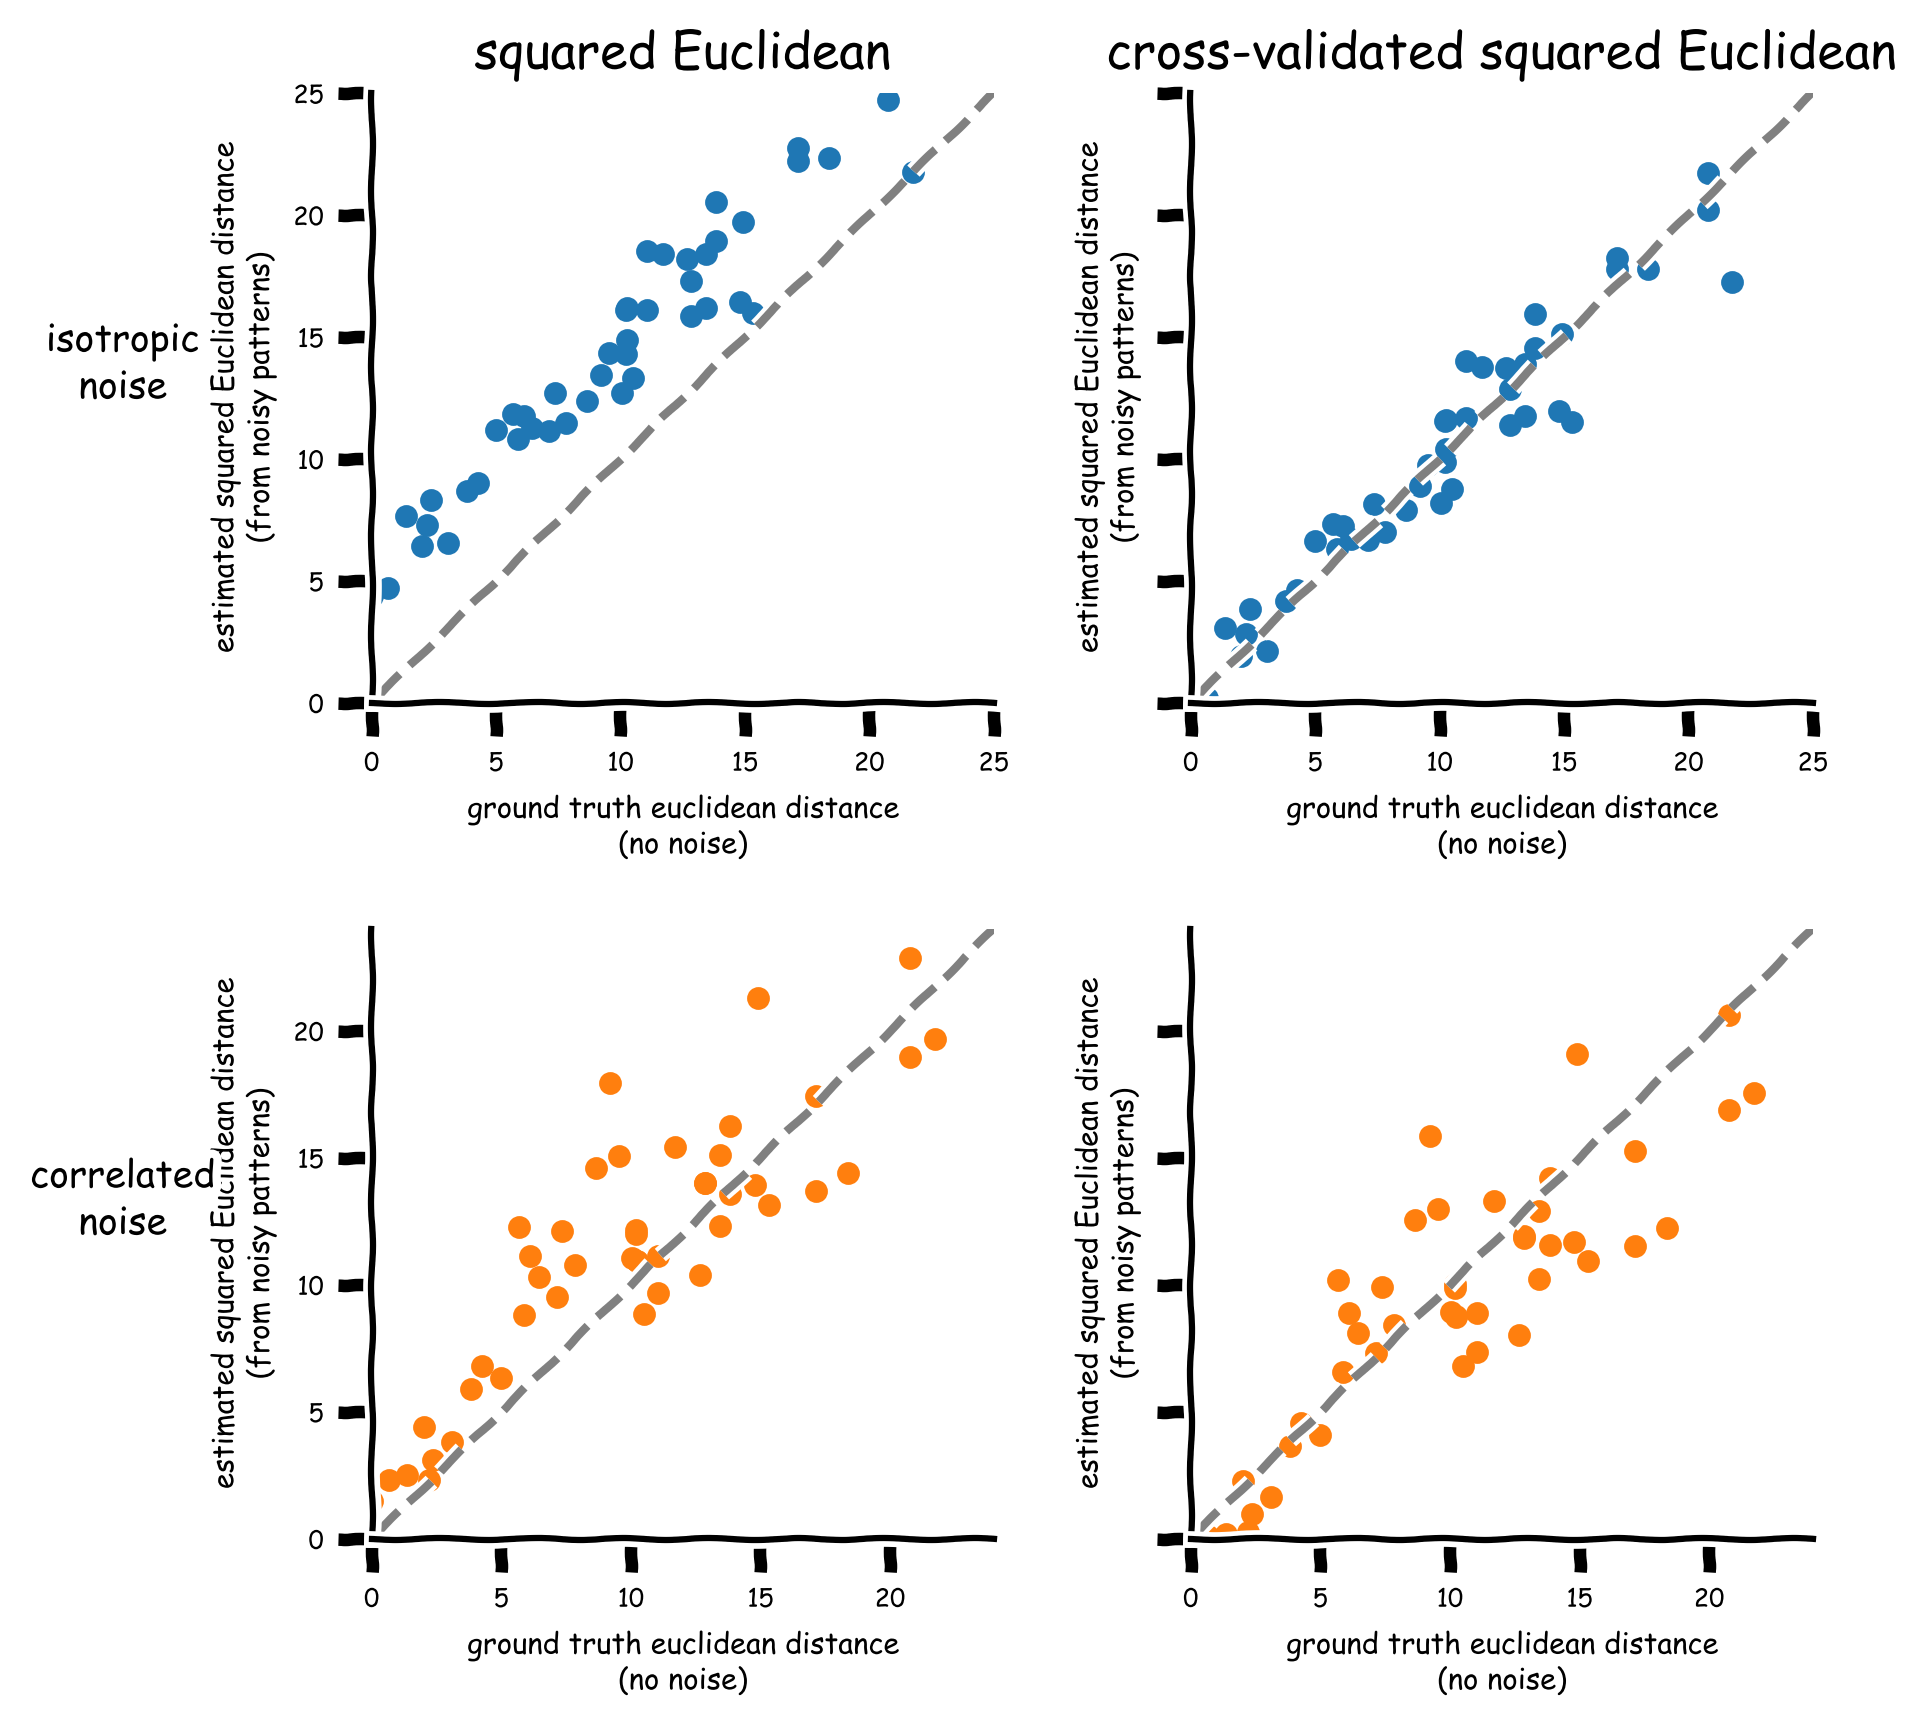

In [26]:
plot_estimated_distance(rdm_euclidean, noisy_rdm_euclidean, noisy_rdm_crossclidean, n_neurons=100)

In section 2, we used the Fisher Linear Discriminant Analysis (LDA) to decode stimuli and calculated decoding accuracy. The weight vector of the Fisher linear discriminant $\mathbf{w}=(\mathbf{b_i}-\mathbf{b_j})_{\text{train}}\Sigma_{\text{train}}^{-1}$. Do you notice any similarity with the cross-validated Mahalanobis distance $(\mathbf{b_i} - \mathbf{b_j})_\text{train}\Sigma_{\text{train}}^{-1}(\mathbf{b_i} - \mathbf{b_j})_\text{test}^T$?
In fact, if the test dataset only consists of one observation from each of the two classes ($\mathbf{b_i^{\textbf{test}}}$ and $\mathbf{b_j}^{\textbf{test}}$) and we subtract the mean pattern from both the training and the test dataset, then both observations in the test set will be correctly classified if $(\mathbf{b_i} - \mathbf{b_j})_\text{train}\Sigma_{\text{train}}^{-1}(\mathbf{b_i} - \mathbf{b_j})_\text{test}^T>0$.
The cross-validated Mahalanobis (crossnobis) distance is closely related to the Fisher linear discriminant and is also known as the *linear discriminant contrast* (*LDC*). In LDA, the discriminant makes a binary classification for each stimulus-related response measurement. Computing the accuracy requires thresholding, a form of discretization, and the accuracy will saturate at 100% if the two means are far apart. The crossnobis estimator (=LDC), by contrast, provides a continuous quantification of the discriminability between stimulus classes, avoiding discretization and saturation (Walther et al. 2016).

In [27]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_cross_validated_distances_prevent_the_inflation_of_distance_estimates_by_noise")

---
# Section 4: The Johnson-Lindenstrauss Lemma

The Johnson-Lindenstrauss Lemma says that random projections approximately preserve Euclidean distances. In particular, to approximately capture the distances of points in a very high-dimensional space, such as a neural response space (many neurons!), we do not necessarily need to measure all neurons. We can estimate the neural-population distances from a random sample of neurons. In fact, the number of random projections that suffices to achieve a given distortion $\epsilon$ is not dependent on the number of original dimensions (neurons here), but only on the number of points (stimuli here).

We will see that we can preserve the distances quite well when embedding high-dimensional points in a space of much lower dimension.

This is a very important property of distances that makes them practically useable in neuroscience applications, where we get much fewer measurement dimensions than the number of neurons in the cortical area we are studying. For example, neural recordings capture a very small fraction of neurons but can be construed as a particular kind of random sample of projections. In functional MRI, voxels contain many neurons and give average responses. However, to the extent that voxels average random sets of neurons, they provide a set of random projections of the neural responses. The Johnson-Lindenstrauss Lemma gives us the hope that these few randomly chosen measurement dimensions will allow a meaningful approximation of the distances and, thus, meaningful comparisons between models and brains.

In data science, random projections are an approach to handling big, high-dimensional data. The Johnson-Lindenstrauss Lemma is important across many disciplines.

We choose one pair of stimuli for illustration purposes. After we project the data onto a dimension $m$ (where $m=2, 4, 8,\ldots, 512$), we calculate the Euclidean distance between the stimulus pair in the projected space and compare it with the distance in the original space.

## Coding exercise 3: Random projections

Generate a random projection matrix $A$ from the original space to the $d$ dimensional space inside the for loop. The entries of $A$ can be filled with random normal variables.

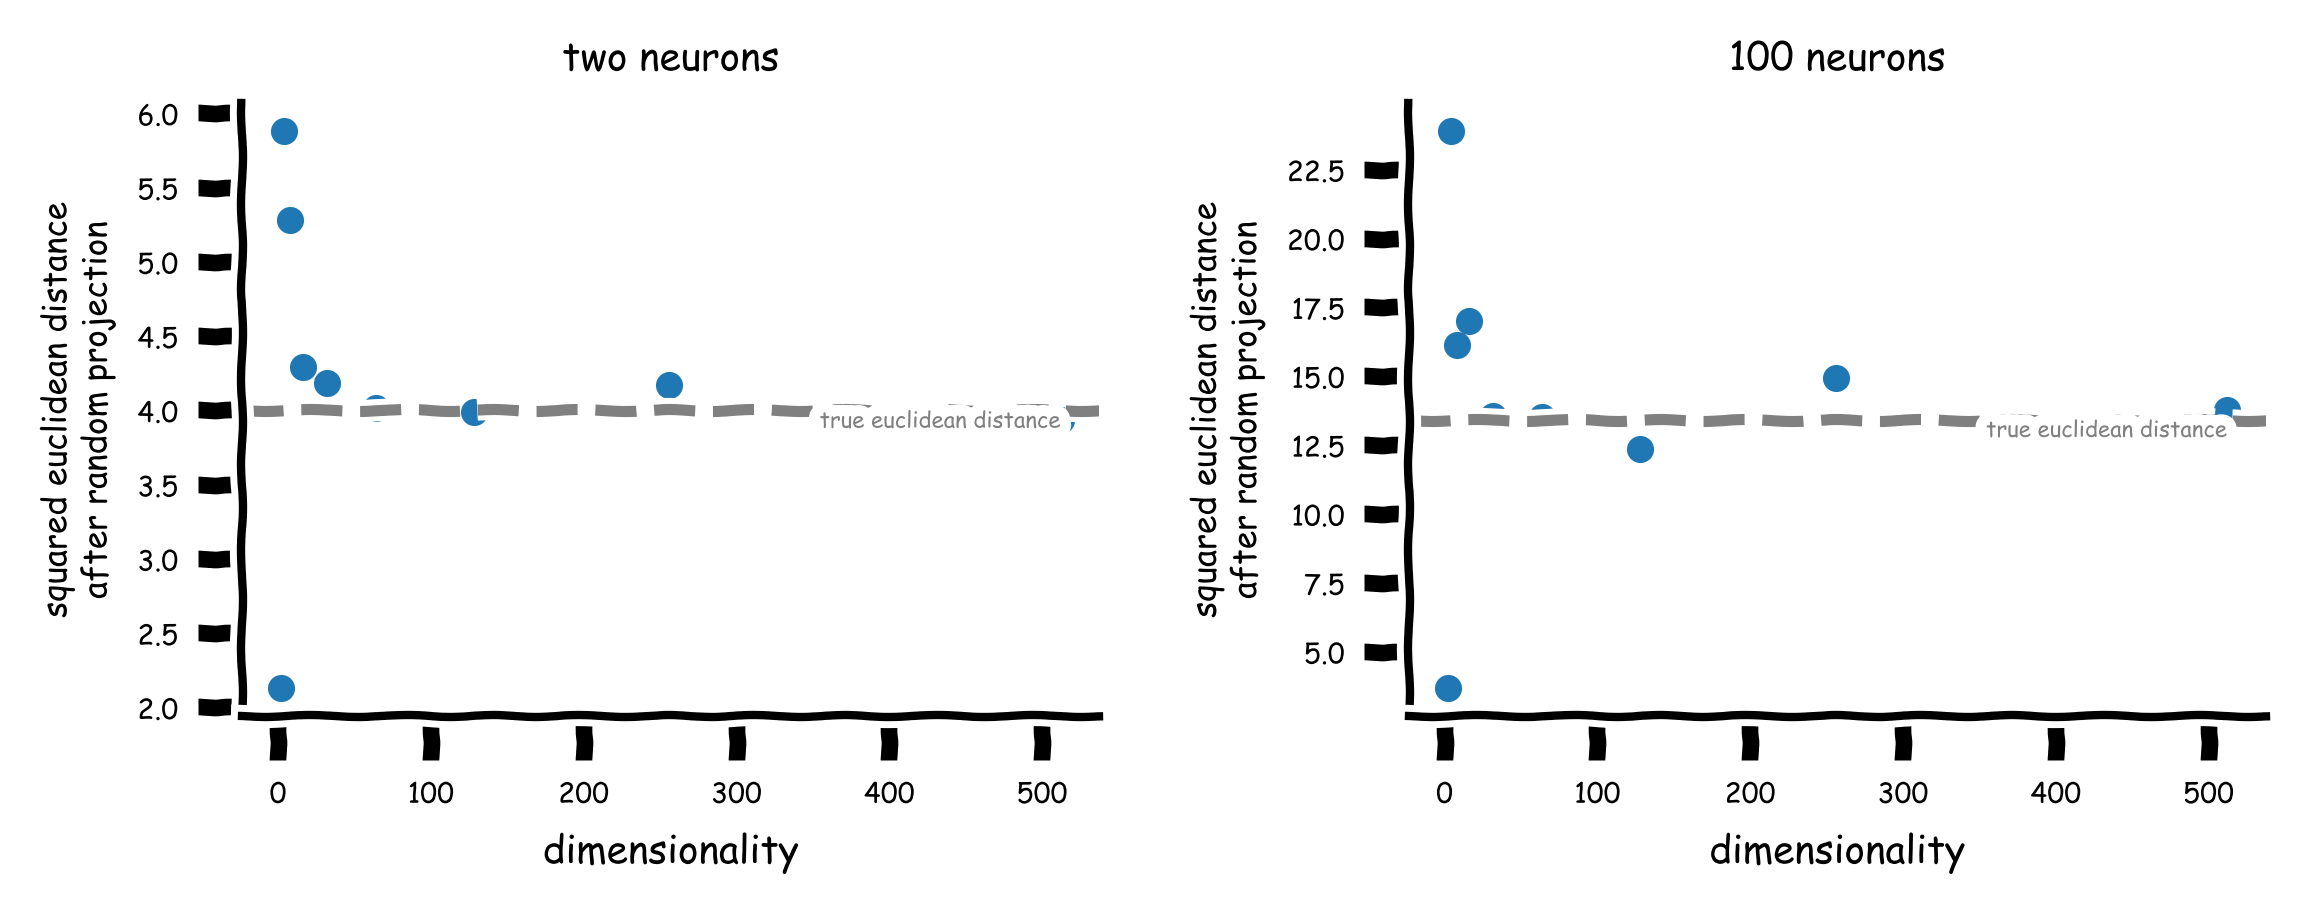

In [29]:
stim_idx = [0,1] # change stimulus index to visualize another pair of stimuli
m_dims_list = np.power(2, np.arange(1,10))
true_dist, projected_dist = {}, {}
for i, n_neurons in enumerate(n_neurons_list):
    data = clean_dataset[n_neurons].sel({"stim": stim_idx})
    # Let's first recalculate the ground truth euclidean rdm again, without normalization by the number of neurons this time.
    true_dist[n_neurons] = calc_rdm(data, method='euclidean', noise=None, normalize_by_channels=False).dissimilarities.item()

    projected_dist[n_neurons]=[]
    for m_dims in m_dims_list:
        #################################################
        # raise NotImplementedError("Student exercise: generate matrix A which projects from dimensionality neurons's amount to d-dimensional space")
        #################################################
        A = np.random.normal(loc=0.0, scale=1, size=(n_neurons, m_dims))
        A *= np.sqrt(1/m_dims)
        transformed_data = (data.values @ A)
        transformed_data = np2xr(transformed_data, coords={'stim': data.stim.values, 'neuron': np.arange(m_dims)})
        rdm = calc_rdm(transformed_data, method='euclidean', noise=None, normalize_by_channels=False)
        projected_dist[n_neurons].append(rdm.dissimilarities.item())
    projected_dist[n_neurons] = np.array(projected_dist[n_neurons])

plot_distance_after_projection(true_dist, projected_dist, n_neurons_list, m_dims_list)

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/solutions/W1D3_Tutorial4_Solution_1ac2083f.py)

*Example output:*

<img alt='Solution hint' align='left' width=461.0 height=182.0 src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/static/W1D3_Tutorial4_Solution_1ac2083f_0.png>



Notice that the distance in the transformed space is close to the original distance for relatively small $k$.

## Discussion

1. Does the amount of distortion after projection depend on the dimension $d$ of the original space? Observe the dimension $k$ that preserves Euclidean distance up to a small distortion for both the 2-neuron and 100-neuron datasets.

2. What is the distance between two identical stimuli after random projection?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/solutions/W1D3_Tutorial4_Solution_05135f17.py)

1. No. Empirically, the dimension that preserves Euclidean distance up to a small distortion for the 100-neuron dataset is similar to the 2-neuron dataset. Theoretically, the distortion bound is independent of the original dimension (https://en.wikipedia.org/wiki/Johnson%E2%80%93Lindenstrauss_lemma).

2. The distance is always 0.

In [28]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_random_projections")

---
# Summary

*Estimated timing of tutorial: 1 hour*

In this tutorial, we have learned:

1. The differences between the (squared) Euclidean and Mahalanobis distance measures. The Mahalanobis distance takes into account the noise covariances between neurons, while the Euclidean distance assumes isotropic noise.
2. Representational distance reflects discriminability (decodability) between stimulus pairs (Kriegeskorte & Diedrichsen, 2019).
   - If we assume additive Gaussian noise that is independent and identically distributed across neurons (isotropic) and stimuli (homoscedastic), then the Euclidean distance in the multivariate response space precisely defines the discriminability of a pair of stimuli in the representation.
   - If we assume that the noise is correlated across neurons (nonisotropic) and i.i.d across stimuli (homoscedastic), then the Mahalanobis distance defines the discriminability.
3. Cross-validated distance estimators (cross-validated Euclidean or Mahalanobis distance) can remove the positive bias introduced by noise.
4. The Johnson–Lindenstrauss Lemma shows that random projections preserve the Euclidean distance with some distortions. Crucially, the distortion does not depend on the dimensionality of the original space.

# The Big Picture

The goal of this tutorial is to provide you with some mathematical tools for your NeuroAI researcher toolkit. What happens when you pull out the Euclidean metric from your toolkit and, while this has worked well in the past, suddenly in different scenarios it doesn't seem to perform so well. Aha, you spot the potential for correlated noise and you reach deeper into your toolkit and pull out the Mahalanobis metric, which implicitly undoes the correlated noise in the model. Perhaps you can't even tell if there is any correlated noise in your data and you try with both metrics, and Mahalanobis works well but Euclidean does not, that can be a hunch that leads you to confirm the presence of correlated noise.

Sometimes you might be faced with dimensionalities that are just too high to practically deal with in your use case. Then, why not recall what you learned about how random projections can reduce the dimensionality of a feature space and be largely resistant to corrupting the applicability of distance metrics. These metrics also might work better in this lower dimensional space. If you apply this idea and need to justify it, just reach into your NeuroAI toolkit and pull out the Johnson-Lindenstrauss Lemma as your justification.